In [1]:
using DataFrames
using Plots

In [2]:
# O(Nlog(N)) with sort
function distribution(X,p)
    d = DataFrame(X = X, p = p)
    d = d[d.p .> 0,:]
    d = combine(groupby(d, ["X"]),df -> DataFrame(p = sum(df.p)) ) 
    sort!(d,["X"]) 
    return d
end

# This delta function is the inverse of cumsum
function delta(V)
    return [V[1];V[Not(1)]-V[Not(length(V))]]
end
            
function neat_CVaR(d,alpha) # O(N)
    if alpha == 0
        return minimum(d[d.p .> 0,:].X)
    else
        return (transpose(d.DeltaX)*max.(zeros(nrow(d)),alpha .- d.Psum .+ d.p))/alpha
    end
end

# CVaR method to solve for multiple Alphas
function neat_CVaR_Vec(d,Alpha)
    d.DeltaX = delta(d.X)      # O(N)
    d.Psum = cumsum(d.p)   # O(N)
    return [neat_CVaR(d,alpha) for alpha in Alpha]
end
                        
function CVaR2Distribution( cvar , lambda ; sig = 10)
    p = delta( lambda )
    X = round.( delta( lambda .* cvar ) ./ (p) ;sigdigits = sig)
    d = distribution(X,p)
    return d
end

CVaR2Distribution (generic function with 1 method)

In [3]:
s1a1 = DataFrame(X = [-600,600], p = [0.25,0.75])
s1a2 = DataFrame(X = [0], p = [1.0])
s1a3 = DataFrame(X = [-100,400], p = [0.5,0.5])
s2 = DataFrame(X = [200], p = [1.0])

Alpha = LinRange(0,1,1001)
s1a1CVaR = neat_CVaR_Vec(s1a1,Alpha);
s1a2CVaR = neat_CVaR_Vec(s1a2,Alpha);
s1a3CVaR = neat_CVaR_Vec(s1a3,Alpha);
s1optCVaR = max.(s1a1CVaR,s1a2CVaR,s1a3CVaR);
s1opt = CVaR2Distribution( s1optCVaR , Alpha);

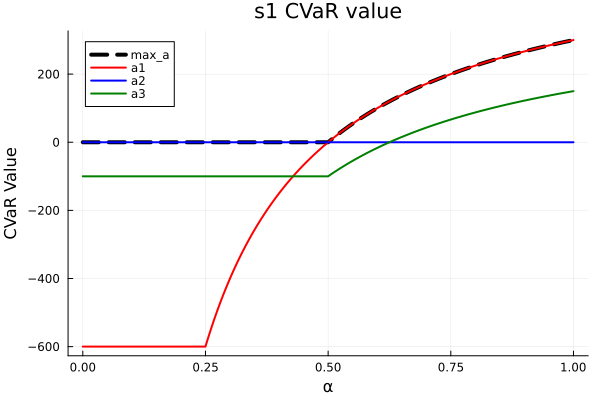

In [4]:
plot(
    Alpha,
    [s1optCVaR s1a1CVaR s1a2CVaR s1a3CVaR],
    title="s1 CVaR value",
    label=["max_a" "a1" "a2" "a3"],
    linestyle = [:dash :solid :solid :solid],
    lc = ["black" "red" "blue" "green"],
    linewidth=[ 4 2 2 2 ])
ylabel!("CVaR Value")
xlabel!("α")

In [5]:
jointopt = distribution([s1opt.X;s2.X],[s1opt.p .* 0.5;s2.p .* 0.5])
jointa1 = distribution([s1a1.X;s2.X],[s1a1.p .* 0.5;s2.p .* 0.5])
jointa2 = distribution([s1a2.X;s2.X],[s1a2.p .* 0.5;s2.p .* 0.5])
jointa3 = distribution([s1a3.X;s2.X],[s1a3.p .* 0.5;s2.p .* 0.5])
jointExpectedCVaR = neat_CVaR_Vec(jointopt,Alpha);
jointa1CVaR = neat_CVaR_Vec(jointa1,Alpha);
jointa2CVaR = neat_CVaR_Vec(jointa2,Alpha);
jointa3CVaR = neat_CVaR_Vec(jointa3,Alpha);
jointoptCVaR = max.(jointa1CVaR,jointa2CVaR,jointa3CVaR);
jointPerformCVaR = jointa2CVaR .* (abs.(jointExpectedCVaR .- jointa2CVaR) .< 1e-12) .+ jointa1CVaR .* (abs.(jointExpectedCVaR .- jointa2CVaR) .>= 1e-12);

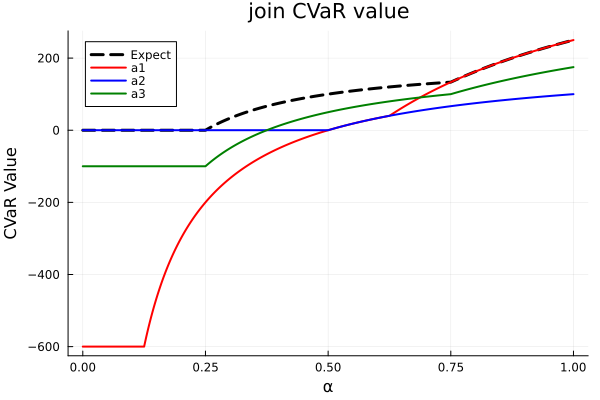

In [6]:
plot(
    Alpha,
    [jointExpectedCVaR jointa1CVaR jointa2CVaR jointa3CVaR],
    title="join CVaR value", label=["Expect" "a1" "a2" "a3"], 
    linestyle = [:dash :solid :solid :solid],
    lc = ["black" "red" "blue" "green"],
    linewidth=[ 3 2 2 2 ])
ylabel!("CVaR Value")
xlabel!("α")

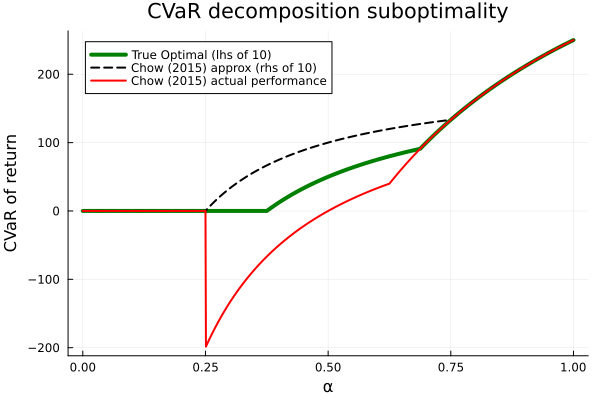

In [7]:
plot(
    Alpha,
    [jointoptCVaR jointExpectedCVaR jointPerformCVaR],
    title="CVaR decomposition suboptimality", 
    linestyle = [:solid :dash :solid],
    label=["True Optimal (lhs of 10)" "Chow (2015) approx (rhs of 10) "  "Chow (2015) actual performance"], 
    lc = ["green" "black" "red"], 
    linewidth=[ 4 2 2 ])
ylabel!("CVaR of return")
xlabel!("α")

In [8]:
savefig("CVaRsuboptimality2.pdf")

"C:\\GITHUB\\RiskAverseRL\\code\\CVaRMDP\\CVaRsuboptimality2.pdf"

## Plotting to pdf

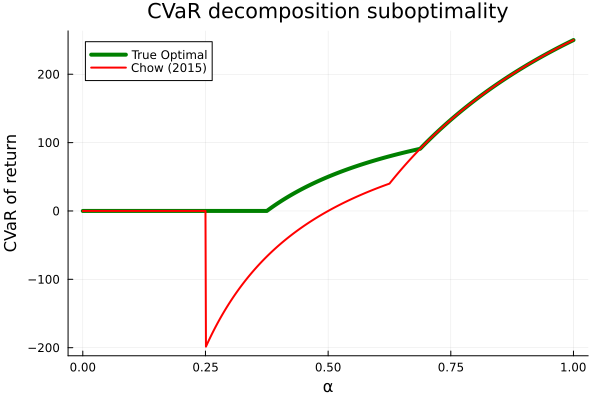

In [9]:
plot(
    Alpha,
    [jointoptCVaR jointPerformCVaR],
    title="CVaR decomposition suboptimality", 
    linestyle = [:solid :solid],
    label=["True Optimal" "Chow (2015)"], 
    lc = ["green" "red"], 
    linewidth=[4 2 ])
ylabel!("CVaR of return")
xlabel!("α")

In [10]:
savefig("CVaRsuboptimality.pdf")

"C:\\GITHUB\\RiskAverseRL\\code\\CVaRMDP\\CVaRsuboptimality.pdf"

## Inspecting $\zeta$ function at $\alpha=0.5$.

In [11]:
Z = LinRange(0,1,10001)
Za1 = max.(s2.X[1] .+ (s1a1.X[1] - s2.X[1]) .* Z, (s2.X[1] + (s1a1.X[1] - s2.X[1]) * s1a1.p[1]) .+ (s1a1.X[2] - s2.X[1]) .* (Z .- s1a1.p[1]))
Za2 = s2.X[1] .+ (s1a2.X[1] - s2.X[1]) .* Z
Za3 = max.( s2.X[1] .+ (s1a3.X[1] - s2.X[1]) .* Z , (s2.X[1] + (s1a3.X[1] - s2.X[1]) * s1a3.p[1]) .+ (s1a3.X[2] - s2.X[1]) .* (Z .- s1a3.p[1]))
Zexp = max.(Za1,Za2,Za3)

expI = argmin(Zexp)
expVal = minimum(Zexp)

trueI = argmin(Za3)
trueVal = minimum(Za3);

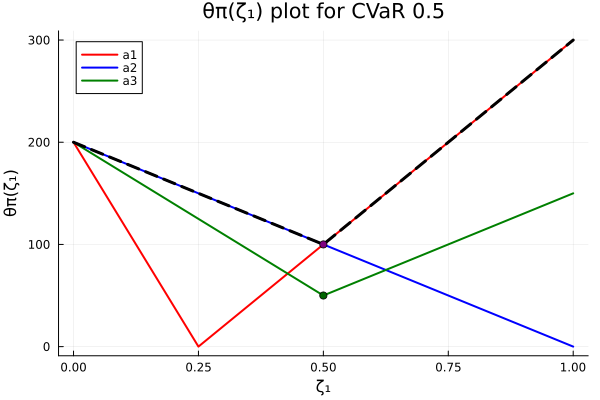

In [12]:
plot(
    Z,
    [Za1 Za2 Za3 Zexp],
    title="θπ(ζ₁) plot for CVaR 0.5", 
    label=["a1" "a2" "a3" ""], 
    linestyle = [:solid :solid :solid :dash ],
    lc = ["red" "blue" "green" "black"], 
    linewidth=[ 2 2 2 3 ])
ylabel!("θπ(ζ₁)")
xlabel!("ζ₁")
plot!([Z[expI]], [expVal], seriestype=:scatter,color="purple",label="")
plot!([Z[trueI]], [trueVal], seriestype=:scatter,color="darkgreen",label="")

For CVaR 50% in this case the the policy optimization risk decomposition would gives us the purple value $100$. However, the true optimal action a3 has a value of $50$. When one deploy the action suggested by the algorithm then they would receive $0$ instead of the optimal $50$ as their CVaR50%.